# For nice plots


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from tapm import utils

# Parameters of the system and basic function definitions

In [2]:
# Parameters
args, y0 = utils.read_params(filename="model_params.txt")


def calculate_m(
    H, min_exp=args["min_exp"], max_exp=args["max_exp"], tau_exp=args["tau_exp"]
):
    return min_exp + (max_exp - min_exp) * (1 - np.exp(-H / tau_exp))


def calculate_lambda_a(args, lambda_P, m, P, H):
    return (lambda_P * P) + (args["c"] * (1 - m) * args["beta_HIV"] * H * (1 - P))


def calculate_lambda_s(args, lambda_a):
    return args["lambda_s"] + lambda_a


# Alpha
def calculate_alpha(P, m, args):
    return args["beta_STI"] * (1 - m * (1 - P))


def calculate_a(args, lambda_s):
    return lambda_s + args["mu"]


def calculate_b(args, lambda_a):
    return args["gamma_STI"] + lambda_a + args["mu"]


def calculate_R_0(args, b, alpha, a):
    return (
        ((args["asymptomatic"] * alpha * a / b) + (1 - args["asymptomatic"]) * alpha)
    ) / a


def calculate_Omega(args, b, a):
    return (b / a) * (1 - args["asymptomatic"]) / args["asymptomatic"]


def calculate_I_STI_a(args, lambda_P, H, P):

    # Calculate a, b, and R_0

    m = calculate_m(H)

    lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
    lambda_s = calculate_lambda_s(args, lambda_a)

    alpha = calculate_alpha(P, m, args)
    a = calculate_a(args, lambda_s)
    b = calculate_b(args, lambda_a)

    R_0 = calculate_R_0(args, b, alpha, a)

    # Calculate I_STI^a,*

    numerator = (args["mu"] + args["gammaT_STI"]) * (1 / R_0 - 1)

    denominator = (
        -b / args["asymptomatic"]
        + args["gamma_STI"]
        - args["gammaT_STI"]
        * (1 + (b / a) * (1 - args["asymptomatic"]) / args["asymptomatic"])
    )

    I_STI_a_star = numerator / denominator

    return I_STI_a_star


def calculate_I_Assymp(args, lambda_P, H, P):

    # Calculate a, b, and R_0

    m = calculate_m(H)

    lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
    lambda_s = calculate_lambda_s(args, lambda_a)

    a = calculate_a(args, lambda_s)
    b = calculate_b(args, lambda_a)

    varphi = b + a * args["asymptomatic"] - b * args["asymptomatic"]

    Ro = calculate_Ro(args, lambda_P, H, P)

    # Calculate I_STI^a,*

    numerator = (
        (args["mu"] + args["gammaT_STI"]) * a * args["asymptomatic"] * (1 - 1 / Ro)
    )

    denominator = (
        (a * b)
        - (a * args["gamma_STI"] * args["asymptomatic"])
        + (args["gammaT_STI"] * varphi)
    )

    I_STI_a_star = numerator / denominator

    return I_STI_a_star


def calculate_S(args, lambda_P, H, P):

    m = calculate_m(H)

    lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
    lambda_s = calculate_lambda_s(args, lambda_a)

    alpha = calculate_alpha(P, m, args)
    a = calculate_a(args, lambda_s)
    b = calculate_b(args, lambda_a)

    varphi = b + a * args["asymptomatic"] - b * args["asymptomatic"]

    S_math = a * b / (alpha * (varphi))

    return S_math


def calculate_Ro(args, lambda_P, H, P):
    S = calculate_S(args, lambda_P, H, P)

    Ro = 1 / S

    return Ro


def calculate_I_Symp(args, lambda_P, H, P):

    m = calculate_m(H)

    lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
    lambda_s = calculate_lambda_s(args, lambda_a)
    a = calculate_a(args, lambda_s)
    b = calculate_b(args, lambda_a)

    asym = calculate_I_Assymp(args, lambda_P, H, P)

    return asym * (b / a) * (1 - args["asymptomatic"]) / args["asymptomatic"]

## N OBS

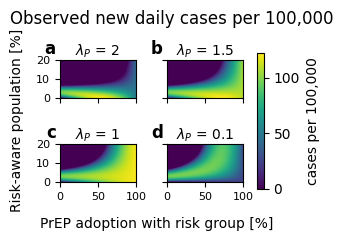

In [7]:
# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define the specific values for lambda_P that you want to represent
lambda_P_values = [
    2 / 360.0,
    1.5 / 360.0,
    1 / 360.0,
    0.1 / 360.0,
]

lambda_P_labels = [
    "2",
    "1.5",
    "1",
    "0.1",
]

results = {}
for lambda_P in lambda_P_values:
    result = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            m = calculate_m(H)
            lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
            lambda_s = calculate_lambda_s(args, lambda_a)
            alpha = calculate_alpha(P, m)
            a = calculate_a(args, lambda_s)
            b = calculate_b(args, lambda_a)
            if calculate_Ro(args, lambda_P, H, P) > 1:
                result[i, j] = lambda_a * calculate_I_Assymp(
                    args, lambda_P, H, P
                ) + lambda_s * calculate_I_Symp(args, lambda_P, H, P)
    results[lambda_P] = result

# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P].flatten() for lambda_P in lambda_P_values]
)
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

# Adjusted Plotting
fig, axes = plt.subplots(
    2, 2, figsize=(3, 2), constrained_layout=False  # 2x2 grid for 4 subplots
)

# Reduce spacing between plots
plt.subplots_adjust(wspace=0.4, hspace=0.2)

# Plot each subplot
for idx, (lambda_P, label) in enumerate(zip(lambda_P_values, lambda_P_labels)):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\\lambda_P$ = {label}", fontsize=10, pad=2)

    # Set xlabels only on the bottom most subplots
    if idx // 2 == 1:
        ax.set_xlabel("", fontsize=8)
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[100] * 100),
                int(Ps[200] * 100),
            ],
            fontsize=8,
        )
    else:
        # Show the middle tick without labels for top subplots
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels([])

    # Set ylabels only on the left most subplots
    if idx % 2 == 0:
        ax.set_ylabel("", fontsize=8)
        ax.set_yticks([0, 50, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[50] * 100),
                int(Hs[100] * 100),
            ],
            fontsize=8,
        )
    else:
        ax.set_yticklabels([])

    # Adding subpanel letters aligned with λ_P titles
    ax.text(
        -0.05,
        1.05,
        chr(97 + idx),  # 'chr(97)' gives 'a', 'chr(98)' gives 'b', etc.
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="bottom",
        ha="right",
    )


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.06,  # Increased padding to move color bar to the right
)

# Shared axis labels
fig.text(0.45, -0.04, "PrEP adoption with risk group [%]", ha="center", fontsize=10)
fig.text(
    -0.04,
    0.5,
    "Risk-aware population [%]",
    va="center",
    rotation="vertical",
    fontsize=10,
)

cbar.ax.set_ylabel("cases per 100,000")
cbar.ax.set_ylabel("cases per 100,000")
fig.suptitle("Observed new daily cases per 100,000", fontsize=12, y=1.05)
plt.show()

## N Real

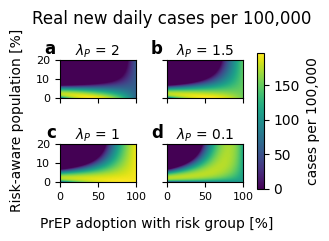

In [8]:
# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define the specific values for lambda_P that you want to represent
lambda_P_values = [
    2 / 360.0,
    1.5 / 360.0,
    1 / 360.0,
    0.1 / 360.0,
]

lambda_P_labels = [
    "2",
    "1.5",
    "1",
    "0.1",
]

results = {}
for lambda_P in lambda_P_values:
    result = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            m = calculate_m(H)
            lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
            lambda_s = calculate_lambda_s(args, lambda_a)
            alpha = calculate_alpha(P, m)
            a = calculate_a(args, lambda_s)
            b = calculate_b(args, lambda_a)
            S = calculate_S(args, lambda_P, H, P)
            if calculate_Ro(args, lambda_P, H, P) > 1:
                result[i, j] = (
                    args["beta_STI"]
                    * ((1 - m) * (1 - P) + P)
                    * S
                    * (
                        calculate_I_Assymp(args, lambda_P, H, P)
                        + calculate_I_Symp(args, lambda_P, H, P)
                    )
                )
    results[lambda_P] = result

# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P].flatten() for lambda_P in lambda_P_values]
)
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

# Adjusted Plotting
fig, axes = plt.subplots(
    2, 2, figsize=(3, 2), constrained_layout=False  # 2x2 grid for 4 subplots
)

# Reduce spacing between plots
plt.subplots_adjust(wspace=0.4, hspace=0.2)

# Plot each subplot
for idx, (lambda_P, label) in enumerate(zip(lambda_P_values, lambda_P_labels)):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\\lambda_P$ = {label}", fontsize=10, pad=2)

    # Set xlabels only on the bottom most subplots
    if idx // 2 == 1:
        ax.set_xlabel("", fontsize=8)
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[100] * 100),
                int(Ps[200] * 100),
            ],
            fontsize=8,
        )
    else:
        # Show the middle tick without labels for top subplots
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels([])

    # Set ylabels only on the left most subplots
    if idx % 2 == 0:
        ax.set_ylabel("", fontsize=8)
        ax.set_yticks([0, 50, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[50] * 100),
                int(Hs[100] * 100),
            ],
            fontsize=8,
        )
    else:
        ax.set_yticklabels([])

    # Adding subpanel letters aligned with λ_P titles
    ax.text(
        -0.05,
        1.05,
        chr(97 + idx),  # 'chr(97)' gives 'a', 'chr(98)' gives 'b', etc.
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="bottom",
        ha="right",
    )


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.06,  # Increased padding to move color bar to the right
)

# Shared axis labels
fig.text(0.45, -0.04, "PrEP adoption with risk group [%]", ha="center", fontsize=10)
fig.text(
    -0.04,
    0.5,
    "Risk-aware population [%]",
    va="center",
    rotation="vertical",
    fontsize=10,
)

cbar.ax.set_ylabel("cases per 100,000")
fig.suptitle("Real new daily cases per 100,000", fontsize=12, y=1.05)
plt.show()

# Final Figure

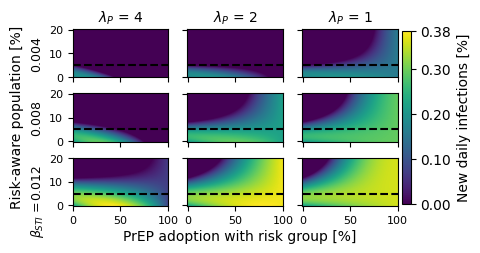

In [3]:
# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define the specific values for lambda_P and beta_STI
lambda_P_values = [
    4 / 360.0,
    2 / 360.0,
    1 / 360.0,
]
lambda_P_labels = ["4", "2", "1"]

beta_STI_values = [
    0.0016 * 5.0,
    0.0016 * 7.5,
    0.0016 * 10.0,
]
beta_STI_labels = ["0.004", "0.008", "0.012"]

results = {}
for beta_STI in beta_STI_values:
    args["beta_STI"] = beta_STI  # Override the beta_STI value in args
    for lambda_P in lambda_P_values:
        result = np.zeros((len(Hs), len(Ps)))
        for i, H in enumerate(Hs):
            for j, P in enumerate(Ps):
                m = calculate_m(H)
                lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
                lambda_s = calculate_lambda_s(args, lambda_a)
                alpha = calculate_alpha(P, m, args)
                a = calculate_a(args, lambda_s)
                b = calculate_b(args, lambda_a)
                S = calculate_S(args, lambda_P, H, P)
                if calculate_Ro(args, lambda_P, H, P) > 1:
                    result[i, j] = (
                        beta_STI  # Now using beta_STI instead of args["beta_STI"]
                        * ((1 - m) * (1 - P) + P)
                        * S
                        * (
                            calculate_I_Assymp(args, lambda_P, H, P)
                            + calculate_I_Symp(args, lambda_P, H, P)
                        )
                    )
        results[(beta_STI, lambda_P)] = result

# Determine the global vmin and vmax
all_infections = np.concatenate(
    [
        results[(beta_STI, lambda_P)].flatten()
        for beta_STI in beta_STI_values
        for lambda_P in lambda_P_values
    ]
)
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

gridspec = {
    "wspace": 0.2,
    "hspace": 0,
    "width_ratios": [1, 1, 1],
    "height_ratios": [1, 1, 1],
}

# Adjusted Plotting
fig, axes = plt.subplots(
    3, 3, figsize=(5.0, 2.5), gridspec_kw=gridspec  # 3x3 grid for 9 subplots
)

# Reduce spacing between plots
# plt.subplots_adjust(wspace=0.1, hspace=-0.1)

# Plot each subplot
for row_idx, beta_STI in enumerate(beta_STI_values):
    for col_idx, (lambda_P, label) in enumerate(zip(lambda_P_values, lambda_P_labels)):
        ax = axes[row_idx, col_idx]
        res_infections = results[(beta_STI, lambda_P)]
        cax = ax.imshow(
            res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax
        )
        if row_idx == 0:
            ax.set_title(f"$\\lambda_P$ = {label}", fontsize=10, pad=5)
        if col_idx == 0:
            ax.set_ylabel(f"{beta_STI_labels[row_idx]}", fontsize=9)

        ax.hlines(np.where(Hs == 0.05)[0][0], 0, 200, color="black", linestyle="--")

        # Set xlabels only on the bottom most subplots
        if row_idx == 2:
            ax.set_xticks([0, 100, 200])
            ax.set_xticklabels(
                [
                    int(Ps[0] * 100),
                    int(Ps[100] * 100),
                    int(Ps[200] * 100),
                ],
                fontsize=8,
            )
        else:
            ax.set_xticks([0, 100, 200])
            ax.set_xticklabels([])

        # Set ylabels only on the left most subplots
        if col_idx == 0:
            ax.set_yticks([0, 50, 100])
            ax.set_yticklabels(
                [
                    int(Hs[0] * 100),
                    int(Hs[50] * 100),
                    int(Hs[100] * 100),
                ],
                fontsize=8,
            )
        else:
            ax.set_yticklabels([])


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e2:.2f}"


# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.9,
    format=FuncFormatter(formatter),
    pad=0.01,  # Increased padding to move color bar to the right
)

# Get existing ticks and replace the last value with global_vmax
ticks = cbar.get_ticks()
ticks[-1] = global_vmax
cbar.set_ticks(ticks)

cbar.ax.set_ylabel("New daily infections [%]")

# Add global x-label and y-label
fig.text(0.46, 0.005, "PrEP adoption with risk group [%]", ha="center", fontsize=10)
fig.text(
    0.00,
    0.5,
    "Risk-aware population [%]",
    va="center",
    rotation="vertical",
    fontsize=10,
)
fig.text(
    0.038, 0.09, "$\\beta_{{STI}}$ =", va="center", rotation="vertical", fontsize=9
)

plt.show()

fig.savefig("../figures/final_figure.pdf", format="pdf", bbox_inches="tight")

# Contour for $R_o=1$

C:\Users\PMallick\AppData\Local\Temp\ipykernel_11776\2009782481.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


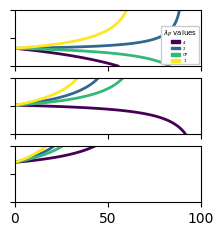

In [8]:
from matplotlib.patches import Patch



def bifurcationP(
    betaSTI,
    lambda_0=args["lambda_0"],
    mu=args["mu"],
    gamma=args["gamma_STI"],
    psi=args["asymptomatic"],
):
    lambdap = (

        psi * (lambda_0 + mu) / ((lambda_0 + mu) / betaSTI - (1 - psi)) - mu - gamma
    )
    return lambdap



# Define the ranges for H and P values


Hs = np.linspace(0, 0.2, 101)


Ps = np.linspace(0, 1.0, 201)



# Define different values for lambda_P


lambda_P_values = [
    4 / 360.0,
    2 / 360.0,
    bifurcationP(betaSTI=0.0016 * 5.0) + 0.01,
    1 / 360.0,
]



lambda_P_labels = [
    "4",
    "2",
    "CP",
    "1",
]



colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_P_values)))



gridspec = {
    "wspace": 0.0,
    "hspace": 0.2,
    "width_ratios": [1],
    "height_ratios": [1, 1, 1],
}



# Adjusted Plotting


fig, axs = plt.subplots(
    3, 1, figsize=(2.4, 2.5), gridspec_kw=gridspec  # 3x3 grid for 9 subplots
)



beta_STI_values = [
    0.0016 * 5.0,
    0.0016 * 7.5,
    0.0016 * 10.0,
]



idx = 0


for ax, betaSTI in zip(axs, beta_STI_values):

    args["beta_STI"] = betaSTI  # Override the beta_STI value in args

    bifur = bifurcationP(betaSTI)

    for lambda_P, color in zip(lambda_P_values, colors):

        # Calculate Ro values for each combination of H and P

        Ro_values = np.zeros((len(Hs), len(Ps)))

        for i, H in enumerate(Hs):

            for j, P in enumerate(Ps):


                Ro_values[i, j] = calculate_Ro(args, lambda_P, H, P)


        # Add a contour line for R_0 = 1

        ax.contour(
            Ps,
            Hs,
            Ro_values,
            levels=[1],
            linewidths=2,
            linestyles="-",
            colors=[color],
        )


    # Titles and labels


    # ax.set_xlabel("P (%)", fontsize=18)

    # ax.set_ylabel("H (%)", fontsize=18)


    # ax.set_title(f"beta_STI = {betaSTI}", fontsize=18)


    # Setting the ticks and labels with larger font size

    ax.set_xticks(np.linspace(Ps.min(), Ps.max(), 3))

    ax.set_xticklabels([f"{int(p * 100)}" for p in np.linspace(Ps.min(), Ps.max(), 3)])


    ax.set_yticklabels([])

    # ax.set_yticks(np.linspace(Hs.min(), Hs.max(), 5))

    # ax.set_yticklabels(


    #     [f"{int(h * 100)}" for h in np.linspace(Hs.min(), Hs.max(), 5)], fontsize=16

    # )



# Remove x-labels for all subplots except the last one


for ax in axs[:-1]:

    ax.set_xticklabels([])



# Adding a custom legend in the first subplot


legend_patches = [
    Patch(color=color, label=label) for color, label in zip(colors, lambda_P_labels)
]


legend = axs[0].legend(
    handles=legend_patches,
    title="$\\lambda_P$ values",
    fontsize=3,
    title_fontsize=5,
    loc="lower right",
)



legend.get_frame().set_facecolor("white")


legend.get_frame().set_alpha(1)



plt.tight_layout()


plt.show()

C:\Users\PMallick\AppData\Local\Temp\ipykernel_10436\815728416.py:226: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


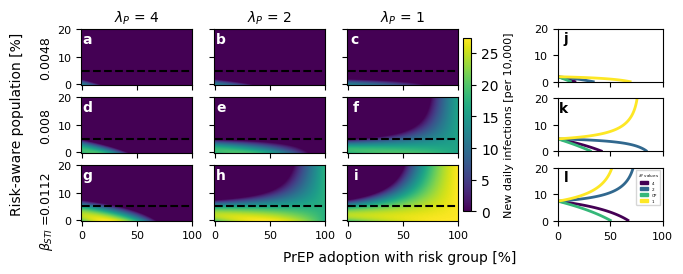

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch


# First figure data generation (3x3)
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

lambda_P_values = [4 / 360.0, 2 / 360.0, 1 / 360.0]
lambda_P_labels = ["4", "2", "1"]
beta_STI_values = [0.0016 * 3.0, 0.0016 * 5.0, 0.0016 * 7.0]
beta_STI_labels = ["0.0048", "0.008", "0.0112"]

results = {}
for beta_STI in beta_STI_values:
    args["beta_STI"] = beta_STI
    for lambda_P in lambda_P_values:
        result = np.zeros((len(Hs), len(Ps)))
        for i, H in enumerate(Hs):
            for j, P in enumerate(Ps):
                m = calculate_m(H)
                lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
                lambda_s = calculate_lambda_s(args, lambda_a)
                alpha = calculate_alpha(P, m, args)
                a = calculate_a(args, lambda_s)
                b = calculate_b(args, lambda_a)
                S = calculate_S(args, lambda_P, H, P)
                if calculate_Ro(args, lambda_P, H, P) > 1:
                    result[i, j] = (
                        beta_STI
                        * ((1 - m) * (1 - P) + P)
                        * S
                        * (
                            calculate_I_Assymp(args, lambda_P, H, P)
                            + calculate_I_Symp(args, lambda_P, H, P)
                        )
                    )
        results[(beta_STI, lambda_P)] = result

all_infections = np.concatenate(
    [
        results[(beta_STI, lambda_P)].flatten()
        for beta_STI in beta_STI_values
        for lambda_P in lambda_P_values
    ]
)
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)


# Second figure data generation (3x1)
def bifurcationP(
    betaSTI,
    lambda_0=args["lambda_s"],
    mu=args["mu"],
    gamma=args["gamma_STI"],
    psi=args["asymptomatic"],
):
    lambdap = (
        psi * (lambda_0 + mu) / ((lambda_0 + mu) / betaSTI - (1 - psi)) - mu - gamma
    )
    return lambdap


lambda_P_values_2 = [
    4 / 360.0,
    2 / 360.0,
    bifurcationP(betaSTI=0.0016 * 5.0) + 0.01,
    1 / 360.0,
]
lambda_P_labels_2 = ["4", "2", "CP", "1"]

colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_P_values_2)))

# Combined plotting
fig = plt.figure(figsize=(7.5, 2.5))

# Adjust width ratios to control the size of the panels
outer_grid = fig.add_gridspec(1, 2, width_ratios=[3.0, 0.7], wspace=0.1)

# First subplot grid (3x3)
left_grid = outer_grid[0].subgridspec(3, 3, wspace=0.2, hspace=0.2)

axes = []
for i in range(3):
    row_axes = []
    for j in range(3):
        ax = fig.add_subplot(left_grid[i, j])
        row_axes.append(ax)
    axes.append(row_axes)

for row_idx, beta_STI in enumerate(beta_STI_values):
    for col_idx, (lambda_P, label) in enumerate(zip(lambda_P_values, lambda_P_labels)):
        ax = axes[row_idx][col_idx]
        res_infections = results[(beta_STI, lambda_P)]
        cax = ax.imshow(
            res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax
        )
        if row_idx == 0:
            ax.set_title(f"$\\lambda_P$ = {label}", fontsize=10, pad=5)
        if col_idx == 0:
            ax.set_ylabel(f"{beta_STI_labels[row_idx]}", fontsize=9)

        ax.hlines(np.where(Hs == 0.05)[0][0], 0, 200, color="black", linestyle="--")

        if row_idx == 2:
            ax.set_xticks([0, 100, 200])
            ax.set_xticklabels(
                [int(Ps[0] * 100), int(Ps[100] * 100), int(Ps[200] * 100)], fontsize=8
            )
        else:
            ax.set_xticks([0, 100, 200])
            ax.set_xticklabels([])

        if col_idx == 0:
            ax.set_yticks([0, 50, 100])
            ax.set_yticklabels(
                [int(Hs[0] * 100), int(Hs[50] * 100), int(Hs[100] * 100)], fontsize=8
            )
        else:
            ax.set_yticks([0, 50, 100])
            ax.set_yticklabels([])

# Add subpanel letters
for idx, ax in enumerate([ax for row_axes in axes for ax in row_axes]):
    ax.text(
        0.1,
        0.95,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=10,
        fontweight="bold",
        va="top",
        ha="right",
        color="white",
    )

# Color bar for first subplot
cbar = fig.colorbar(
    cax,
    ax=[ax for row_axes in axes for ax in row_axes],
    shrink=0.9,
    format=FuncFormatter(lambda x, pos: f"{x * 1e4:.0f}"),
    pad=0.01,
)
# Get existing ticks and replace the last value with global_vmax
# ticks = cbar.get_ticks()
# ticks[-1] = global_vmax
# cbar.set_ticks(ticks)

cbar.ax.set_ylabel("New daily infections [per 10,000]", fontsize=8)

fig.text(0.55, -0.05, "PrEP adoption with risk group [%]", ha="center", fontsize=10)
fig.text(
    0.03,
    0.5,
    "Risk-aware population [%]",
    va="center",
    rotation="vertical",
    fontsize=10,
)
fig.text(
    0.067, 0.07, "$\\beta_{{STI}}$ =", va="center", rotation="vertical", fontsize=9
)

# Second subplot grid (3x1)
right_grid = outer_grid[1].subgridspec(3, 1, hspace=0.3)

axs = []
for i in range(3):
    ax = fig.add_subplot(right_grid[i])
    axs.append(ax)

for ax, betaSTI in zip(axs, beta_STI_values):
    args["beta_STI"] = betaSTI
    bifur = bifurcationP(betaSTI)
    for lambda_P, color in zip(lambda_P_values_2, colors):
        Ro_values = np.zeros((len(Hs), len(Ps)))
        for i, H in enumerate(Hs):
            for j, P in enumerate(Ps):
                Ro_values[i, j] = calculate_Ro(args, lambda_P, H, P)
        ax.contour(
            Ps, Hs, Ro_values, levels=[1], linewidths=2, linestyles="-", colors=[color]
        )

    ax.set_xticks(np.linspace(Ps.min(), Ps.max(), 3))
    ax.set_xticklabels(
        [f"{int(p * 100)}" for p in np.linspace(Ps.min(), Ps.max(), 3)], fontsize=8
    )
    ax.set_yticks([Hs[0], Hs[50], Hs[100]])
    ax.set_yticklabels(
        [int(Hs[0] * 100), int(Hs[50] * 100), int(Hs[100] * 100)], fontsize=8
    )

for ax in axs[:-1]:
    ax.set_xticklabels([])

legend_patches = [
    Patch(color=color, label=label) for color, label in zip(colors, lambda_P_labels_2)
]
legend = axs[2].legend(
    handles=legend_patches,
    title="$\\lambda_P$ values",
    fontsize=3,
    title_fontsize=3,
    loc="upper right",
)
# legend.get_frame().set_facecolor("white")
# legend.get_frame().set_alpha(1)

letters = ["j", "k", "l"]
for idx, ax in enumerate(axs):
    ax.text(
        0.1,
        0.95,
        chr(97 + 9 + idx),
        transform=ax.transAxes,
        fontsize=10,
        fontweight="bold",
        va="top",
        ha="right",
    )

plt.tight_layout()
plt.show()

fig.savefig("../figures/final_figure.pdf", format="pdf", bbox_inches="tight")